# Using beamforming to localize oscillatory power modulations

The aim of this section is to localize modulations of oscillatory power. The will be done using the Linearly Constrained Minimum Variance (LCMV) approach (van Veen et al., 1997). This is a beamforming approach based on spatial filtering. For each grid point in the brain as spatial filter is derived based on the forward model and the covariance matrix. This allow for estamation the power modulations at each grid points which then is mapped onto the indiviual structural MRIs.


### Preparation

Import the relevant Python modules:

In [1]:
import os
import os.path as op
import numpy as np

import mne
from mne.cov import compute_covariance
from mne.beamformer import make_lcmv, apply_lcmv_cov, make_dics, apply_dics_csd
from mne.time_frequency import csd_morlet
from mne.datasets import fetch_fsaverage

Set the paths and name for the data. Note that these will depend on your local setup.

In [2]:
result_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\dataResults'
file_name = 'training_epo.fif'

path_file  = op.join(result_path,file_name) 

### The forward model

For this example we will use a forward model already calculated. Please refer to the <a href="https://mne.tools/dev/auto_tutorials/forward/30_forward.html">MNE documentation</a> for how to calculate the forward model using FreeSurfer.

In [3]:
fwd_fname = r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1-surface_fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)

Reading forward solution from C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1-surface_fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8195 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


This is the forward model constructed for the 306 MEG sensors with respect to the brain surface of 8195 sources (grid points).

# Read the trials

Now read the epochs for all trial types combined. We here focus on the alpha band modulations; therefore bandpass filter the data at 8 to 12 Hz and select the gradiometer data only:

In [4]:
epochs = mne.read_epochs(path_file)

epochs = epochs.pick_types(meg='grad')
#epochs.resample(200)  
#epochs.filter(8, 12)
#epochs.pick_types(meg='grad')
#picks = mne.pick_types(epochs.info, meg='grad')

epochs_left  = epochs['left'].filter(8, 12).copy()
epochs_right = epochs['right'].filter(8, 12).copy()

Reading C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_epo.fif ...
    Found the data of interest:
        t =   -2500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 1651 samples (1.651 sec)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


### Calculating the covariance matrices 

The spatial filters in the LCMV beamforming approach are calculated using the forward model and the covariance matrices. We here focus on the -0.8 to -0.3 s interval prior to the onset of the gratings and the 0.3 to 0.8 s interval when the gratings are presented. During the representation interval, the alpha band activity is suppressed (see the section Time-Frequency Representations of Power). The covarience matrices are calculated for each interval and the combined in order to later create a *common spatial filter*. 

In [5]:
rank = mne.compute_rank(epochs, tol=1e-6, tol_kind='relative')

baseline_left_cov = compute_covariance(epochs_left,tmin=-0.8,tmax=-0.3,method='shrunk',rank=rank,n_jobs = 4,verbose=True)
active_left_cov = compute_covariance(epochs_left,tmin=0.3,tmax=0.8,method='shrunk',rank=rank,n_jobs = 4,verbose=True)

baseline_right_cov = compute_covariance(epochs_right,tmin=-0.8,tmax=-0.3,method='shrunk',rank=rank,n_jobs = 4,verbose=True)
active_right_cov = compute_covariance(epochs_right,tmin=0.3,tmax=0.8,method='shrunk',rank=rank,n_jobs = 4,verbose=True)

common_cov = baseline_left_cov + active_left_cov + baseline_right_cov + active_right_cov 

Computing rank from data with rank=None
    Estimated rank (grad): 69
    GRAD: rank 69 computed from 204 data channels with 0 projectors
Computing rank from data with rank={'grad': 69}
    Setting small GRAD eigenvalues to zero (without PCA)
Reducing data rank from 204 -> 69
Estimating covariance using SHRUNK


C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\cov.py:1023: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion('0.22'):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\cov.py:1023: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion('0.22'):


Done.
Number of samples used : 65130
[done]
Computing rank from data with rank={'grad': 69}
    Setting small GRAD eigenvalues to zero (without PCA)
Reducing data rank from 204 -> 69
Estimating covariance using SHRUNK


C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\cov.py:1023: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion('0.22'):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\cov.py:1023: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion('0.22'):


Done.
Number of samples used : 65130
[done]
Computing rank from data with rank={'grad': 69}
    Setting small GRAD eigenvalues to zero (without PCA)
Reducing data rank from 204 -> 69
Estimating covariance using SHRUNK


C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\cov.py:1023: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion('0.22'):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\cov.py:1023: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion('0.22'):


Done.
Number of samples used : 63126
[done]
Computing rank from data with rank={'grad': 69}
    Setting small GRAD eigenvalues to zero (without PCA)
Reducing data rank from 204 -> 69
Estimating covariance using SHRUNK


C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\cov.py:1023: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion('0.22'):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\cov.py:1023: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion('0.22'):


Done.
Number of samples used : 63126
[done]


Lets now consider the rank for the coveriance matrix: 

{'grad': 69}
Computing rank from covariance with rank=None
    Using tolerance 5.3e-14 (2.2e-16 eps * 204 dim * 1.2  max singular value)
    Estimated rank (grad): 69
    GRAD: rank 69 computed from 204 data channels with 0 projectors


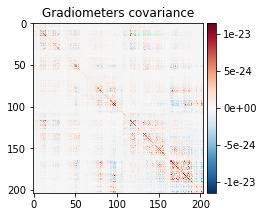

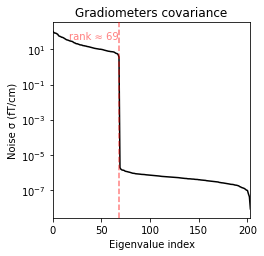

(<Figure size 273.6x266.4 with 2 Axes>, <Figure size 273.6x266.4 with 1 Axes>)

In [17]:
common_cov.plot(epochs_left.info)

Note that the rank is 69 eventhough there were 204 gradiometers used in the calculations. The rank deficiency is caused by the SSS algorithm and therefore requires a regulatization before inverting in the beamforming calculation. 

### Derive the spatial filters

Now calculate the filters using the forward model (*fwd*) and the combined covariance matrix (*common_cov*). The filters were regularized corresponding to loading the diagonal of the covariance matrix with 5% of the sensor power. For each source the orientation was optimized to maximize the power of the output. 

In [6]:
filters = make_lcmv(epochs.info, 
                            fwd, 
                            common_cov, 
                            reg=0.05,
                            noise_cov=None, 
                            pick_ori='max-power') 

Computing rank from covariance with rank='info'
    GRAD: rank 204 after 0 projectors applied to 204 channels
Computing rank from covariance with rank='info'
    GRAD: rank 204 after 0 projectors applied to 204 channels
Making LCMV beamformer with rank {'grad': 204}
Computing inverse operator with 204 channels.
    204 out of 306 channels remain after picking
Selected 204 channels
Whitening the forward solution.
Computing rank from covariance with rank={'grad': 204}
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8195 sources


C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Filter computation complete


### Apply the spatial filters

Then apply the filter to the data for the baseline interval as well as the stimulation interval for the left as well as right attention conditions:

In [7]:
stc_left_base = apply_lcmv_cov(baseline_left_cov, filters)
stc_left_act = apply_lcmv_cov(active_left_cov, filters)
stc_right_base = apply_lcmv_cov(baseline_right_cov, filters)
stc_right_act = apply_lcmv_cov(active_right_cov, filters)

Calculate the relative change in power; i.e. the change in alpha power comparing the interval before and after the moving grating onset:

In [11]:
stc_rel = ((stc_left_act + stc_right_act) - (stc_left_base + stc_right_base)) / (stc_left_base + stc_right_base)

Calculate the changed in relative power for comparing the right versus left attention condutions during the moving gratings:

In [ ]:
stc_RvsL = (stc_right_act - stc_left_act) / (stc_right_act + stc_left_act)

### Plotting the source results

Read the source spaces from the FIF file:

In [9]:
src_fname = r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1-surfaceoct6_src.fif'
src_fs = mne.read_source_spaces(src_fname)

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read


Now plot the source results on the brain surface: 

In [15]:
stc_rel.plot(src=fwd['src'], hemi = 'both' , views = 'parietal', surface = 'inflated',  subject='training1',
                        subjects_dir=r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI');

Using control points [0.26343373 0.28054737 0.33594793]


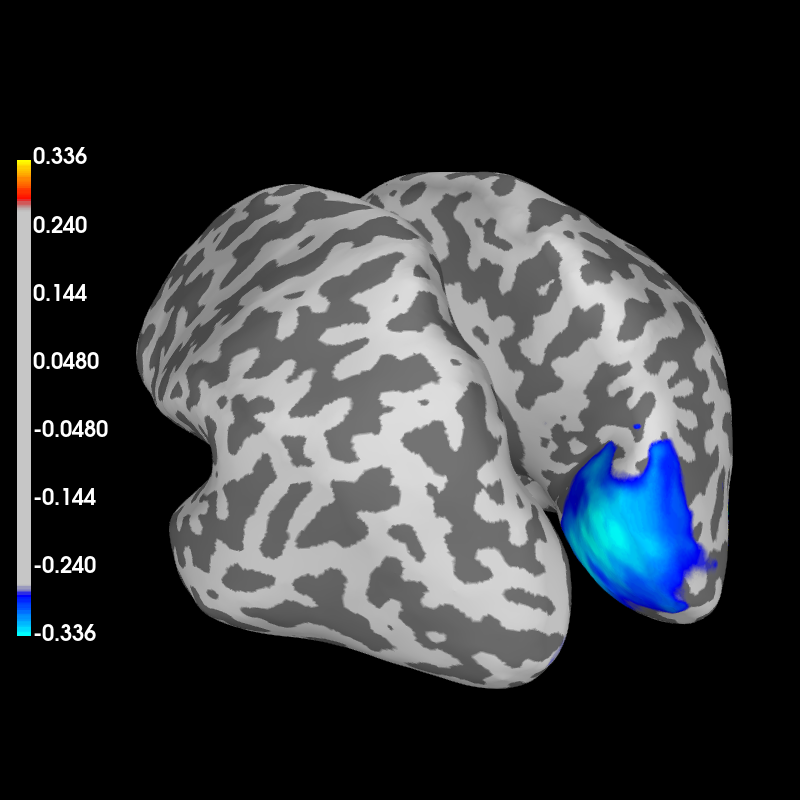

The above plot show the relative depression in the alpha following the onset of moving gratings. The blue island reflects the occipital depression in alpha power. 

In [ ]:
stc_RvsL.plot(src=fwd['src'], hemi = 'both' , views = 'parietal', surface = 'inflated',  subject='training1',
                        subjects_dir=r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI');


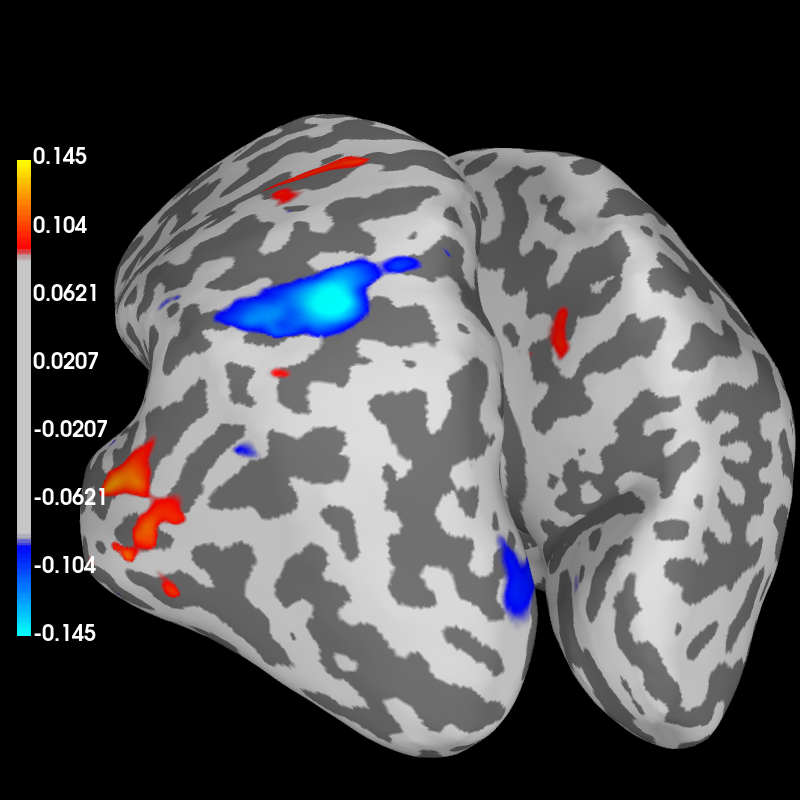

The sources in parieto-occipital areas reflecting the modulation of the alpha band activity when the partipant in attention to the right versus left moving gratings. The parietal blue island reflects the well-known contralateral depression in alpha band power.  

### Preregistration and publications


Example for text to be used for publications and preregistration:

"A Linearly Constrained Minimum Variance (LCMV) approach (van Veen et al., 1997) was applied to localize the modulations of oscillatory brain activity. To localize the modulation in the alpha band, the trial data was bandpass filtered at 8 to 12 Hz. The covariance matrix was then calculated for the 300 - 800 ms stimulus interval in which the gratings were shown as well as the -800 - -300 ms pre-stimulus interval. The combined covariance matrix was used with the forward model to create the spatial filters using a regularization corresponding to loading the diagonal of the covariance matrix with 5% of the sensor power. For each source, the orientation was optimized to maximize the power of the output. The spatial filter was then applied to the bandpass filtered to calculate the relative change in alpha power. "

### References
Van Veen, B.D, van Drongelen, W., Yuchtman, M., and Suzuki, A. (1997). Localization of brain electrical activity via linearly constrained minimum variance spatial filtering. IEEE Transactions on Biomedical Engineering, 44(9):867–880.       